In [131]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [124]:
def generate_sequence(sequence_length, transition_probabilities, num_states, critical_states):
#     init_state = np.random.randint(0, num_states , 1)

    observation_sequence = []
    init_state=3
    current_state = init_state#init state
    state_sequence = np.zeros(sequence_length)
# Generate a single sample from the multivariate normal distribution
    for jj in range(sequence_length):
        mean = [8*current_state, 0]
        cov = [[1, 0], [0, 3]]
        observation = np.random.multivariate_normal(mean, cov)
        observation_sequence.append(observation)
        current_state = np.random.choice(range(num_states), p=transition_probabilities[current_state])
        state_sequence[jj]=current_state
    return np.array(observation_sequence), state_sequence

In [126]:
# Define the number of sequences and the length of each sequence
num_sequences = 1500
sequence_length = 50
num_states=40

# Define the transition probabilities matrix
transition_probabilities = 0.026*np.ones((num_states, num_states))


# Define the critical states
critical_states = np.array([0, 18, 19, 39])
transition_probabilities[:, critical_states] = 0.016
# transition_probabilities /= np.sum(transition_probabilities, axis=1, keepdims=True)

# Generate the dataset of sequences
dataset = []
outcomes = []
state_seqs_list = []
np.random.seed(41)
for _ in range(num_sequences):
    sequence,  state_sequence = generate_sequence(sequence_length, 
                                                                           transition_probabilities, 
                                                                           num_states,
                                                                           critical_states)
    
    dataset.append(sequence)
    
    # Determine the outcome based on the number of transitions to critical states
    critical_transition_inds = np.isin(state_sequence, critical_states)
    high_val_inds = np.logical_or(sequence[:, 1]<=-2.5, sequence[:, 1]>=2.5)
    
    
    high_mid_val_inds = np.logical_or(np.logical_and(sequence[:, 1]<=-1.5, sequence[:, 1]>=-2.5),
                                 np.logical_and(sequence[:, 1]<=2.5, sequence[:, 1]>=1.5))
    
    
    low_mid_val_inds = np.logical_or(np.logical_and(sequence[:, 1]<=-0.5, sequence[:, 1]>=-1.5),
                                 np.logical_and(sequence[:, 1]<=1.5, sequence[:, 1]>=0.5))
    
    
    
    if np.sum(np.logical_and(critical_transition_inds, high_val_inds)) >= 2:
        outcome = 3
    elif np.sum(np.logical_and(critical_transition_inds, high_mid_val_inds)) >= 2:
        outcome = 2
    elif np.sum(np.logical_and(critical_transition_inds, low_mid_val_inds)) >= 2:
        outcome = 1
    else:
        outcome = 0
    
    outcomes.append(outcome)
    state_seqs_list.append(state_sequence)

# Convert the dataset and outcomes to arrays
dataset = np.array(dataset)
outcomes = np.array(outcomes)

# Print the shape of the dataset and outcomes
print("Dataset shape:", dataset.shape)
print("Outcomes shape:", outcomes.shape)

for y in np.unique(outcomes):
    print('Number of outcome %d sequences : %d'%(y, np.sum(outcomes==y)))


Dataset shape: (1500, 50, 2)
Outcomes shape: (1500,)
Number of outcome 0 sequences : 706
Number of outcome 1 sequences : 397
Number of outcome 2 sequences : 261
Number of outcome 3 sequences : 136


## Visualize sequences as time series

<Figure size 720x432 with 0 Axes>

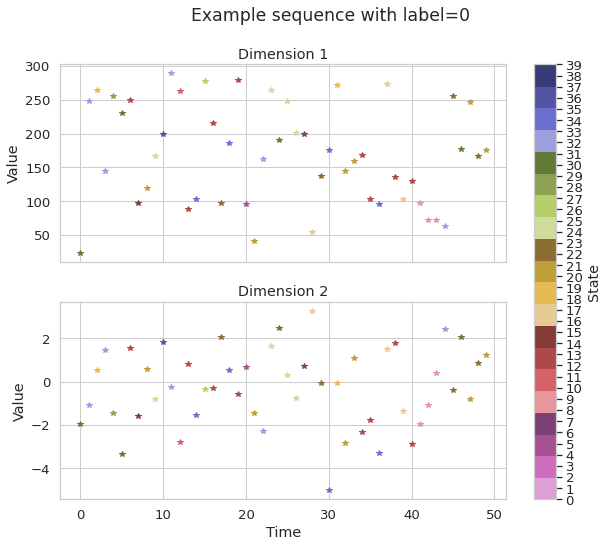

<Figure size 720x432 with 0 Axes>

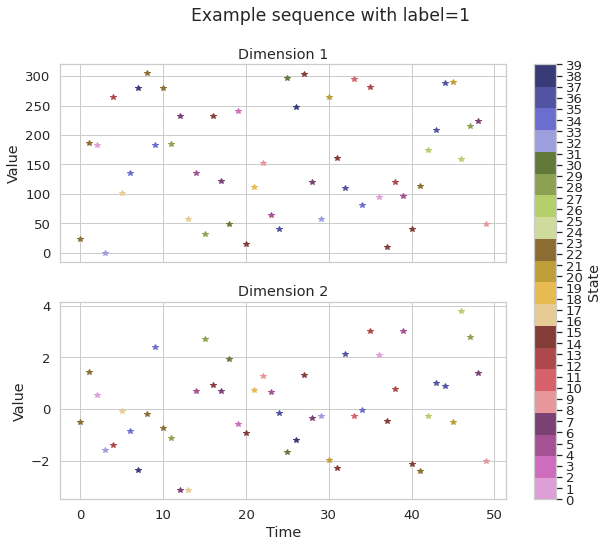

<Figure size 720x432 with 0 Axes>

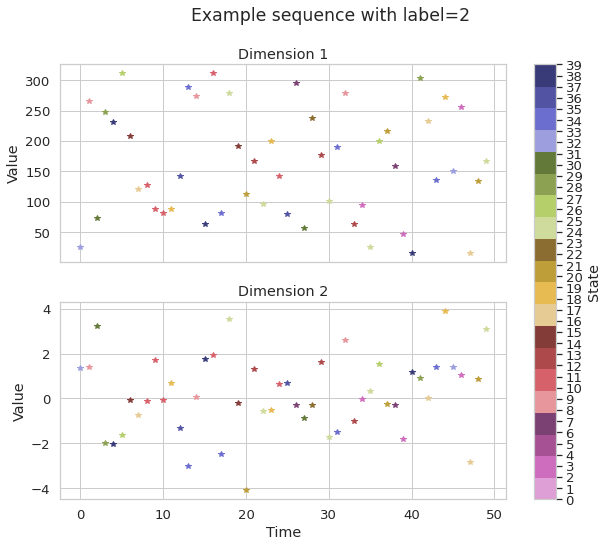

<Figure size 720x432 with 0 Axes>

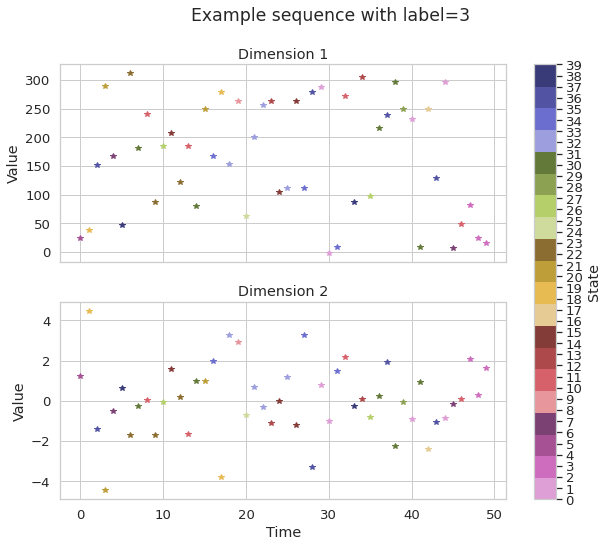

In [139]:
for label in np.unique(outcomes):
    
    # Plot the sequence with state overlay
    cmap = plt.get_cmap("tab20b_r", num_states)
    plt.figure(figsize=(10, 6))
    
    
    # get indexes of sequences with the the required label
    label_inds = np.flatnonzero(outcomes==label)
    
    # plot a single sequence with state overlay
    seq_id=label_inds[-1]
    state_sequence = state_seqs_list[seq_id]
    observation_sequence = dataset[seq_id]

    # Create subplots for each dimension
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    sns.set_context('notebook', font_scale=1.2)
    sns.set_style('whitegrid')

    # Plot each dimension separately
    for i in range(2):
        axs[i].set_title(f"Dimension {i+1}")
        axs[i].set_ylabel("Value")

        # plot sequence with state overlay
        for j in range(num_states):
            idx = np.where(state_sequence == j)
            color = cmap(j / (num_states - 1))  # Normalize state value between 0 and 1
            axs[i].plot(idx[0], np.squeeze(observation_sequence[idx, i]), marker='*', linestyle='None',
                        color=color, alpha=1)

    # Create a single colorbar for both axes
    norm = plt.Normalize(0, num_states - 1)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), ticks=range(num_states))
    cbar.set_label('State')

    # Set x-axis label and ticks on the bottom subplot
    axs[-1].set_xlabel("Time")
    
    fig.suptitle('Example sequence with label=%d'%label)
    # plt.tight_layout()

# Show the plot
plt.show()

## Visualize sequences as 2d scatter plots

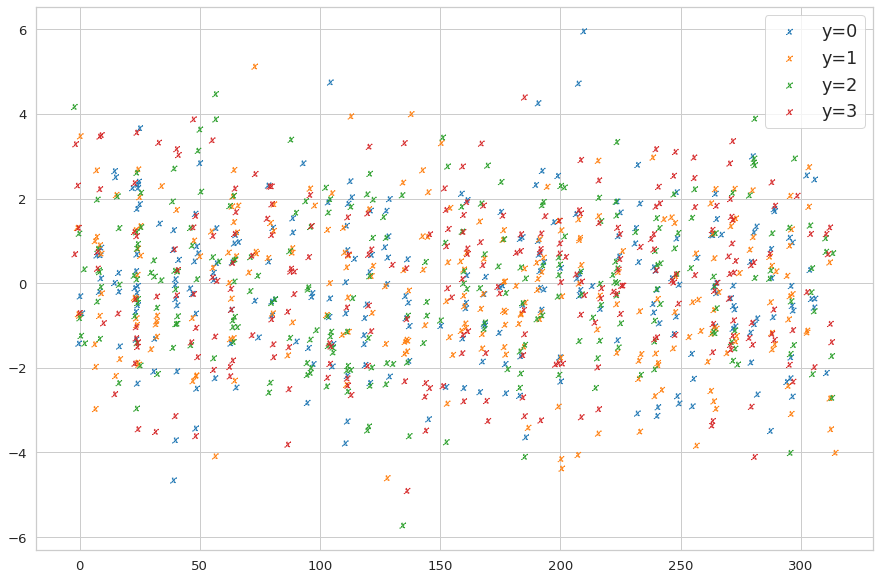

In [127]:
f, axs = plt.subplots(1, 1, figsize=(15, 10))
sns.set_context("notebook", font_scale=1.6)


for jj, ordinal_label in enumerate(np.unique(outcomes)):
    feature_vals_ND_labels_y = dataset[outcomes==ordinal_label][:5]

    # plot time series sequence of example with label 0 and 1
    axs.scatter(feature_vals_ND_labels_y[:, :, 0], feature_vals_ND_labels_y[:, :, 1],
                marker='$x$', linestyle=':',  label=f'y={ordinal_label}')
    
#     axs.set_title('10 sequences with label y=%d'%ordinal_label)
    axs.legend()

plt.show()

# Save the dataset as train/valid/test 

In [132]:
from sklearn.model_selection import train_test_split


# Set the random seed for reproducibility
random_seed = 42

# Split the dataset into train/validation and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(dataset, outcomes, test_size=0.2, 
                                                            random_state=random_seed)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=random_seed)


# Print the sizes of the resulting sets
print("Train set size:", len(y_train))
print("Validation set size:", len(y_val))
print("Test set size:", len(y_test))


save_dir = '/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/data/toydata_many_states'
for split, x, y in [('train', x_train, y_train),
                ('valid', x_val, y_val),
                ('test', x_test, y_test)]:
    for label in np.unique(outcomes):
        print('Number of outcome %d sequences in %s: %d'%(label, split, np.sum(y==label)))
        
print('Saving data to %s'%save_dir)
np.save(os.path.join(save_dir, 'X_train.npy'), x_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
print('Done saving train..')
np.save(os.path.join(save_dir, 'X_valid.npy'), x_val)
np.save(os.path.join(save_dir, 'y_valid.npy'), y_val)
print('Done saving valid..')
np.save(os.path.join(save_dir, 'X_test.npy'), x_test)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)
print('Done saving test..')


Train set size: 960
Validation set size: 240
Test set size: 300
Number of outcome 0 sequences in train: 450
Number of outcome 1 sequences in train: 260
Number of outcome 2 sequences in train: 168
Number of outcome 3 sequences in train: 82
Number of outcome 0 sequences in valid: 121
Number of outcome 1 sequences in valid: 60
Number of outcome 2 sequences in valid: 40
Number of outcome 3 sequences in valid: 19
Number of outcome 0 sequences in test: 135
Number of outcome 1 sequences in test: 77
Number of outcome 2 sequences in test: 53
Number of outcome 3 sequences in test: 35
Saving data to /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/data/toydata_many_states
Done saving train..
Done saving valid..
Done saving test..
